In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import gurobi_logtools as glt

In [5]:
name = "Track_k_e_2_reruns"
PATH = f".\Experiments\{name}\Logs"

In [6]:
result = glt.parse(PATH+"\*.log")
summary = result.summary()


In [7]:

nl = result.progress("nodelog")
print(nl[~nl['Incumbent'].isna()])
nl.head()

      CurrentNode  RemainingNodes      Obj  Depth  IntInf  Incumbent  \
309         41072          2475.0      NaN    NaN     NaN   0.000979   
310         48503          2783.0      NaN   40.0     NaN   0.000980   
311         48825          2749.0      NaN    NaN     NaN   0.000925   
312         49687          2812.0      NaN    NaN     NaN   0.000925   
313         55406          3661.0  0.00084   54.0    44.0   0.000930   
...           ...             ...      ...    ...     ...        ...   
6657      1070354         80486.0      NaN    NaN     NaN   0.000214   
6658      1077338         80835.0  0.00021   77.0    44.0   0.000210   
6659      1091366         51955.0      NaN    NaN     NaN   0.000207   
6660      1091373         36764.0      NaN    NaN     NaN   0.000206   
6661      1091379             NaN      NaN    NaN     NaN   0.000206   

        BestBd       Gap  ItPerNode    Time  \
309   0.000210  0.790000       37.2   12.00   
310   0.000210  0.790000       37.3   15.

c:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\pyomo_env\lib\site-packages\gurobi_logtools\api.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  left=pd.concat(progress),


,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,LogFilePath,LogNumber,Pruned,NewSolution,Seed,Version
0,0,0.0,0.00021,0.0,44.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2
1,0,0.0,0.00021,0.0,74.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2
2,0,0.0,0.00021,0.0,90.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2
3,0,0.0,0.00021,0.0,93.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2
4,0,0.0,0.00021,0.0,91.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2


In [8]:
regex_pattern = r'_r(\d+)_c(\d+)\.log'
nl[['Repetition', 'Config']] = nl['LogFilePath'].str.extract(regex_pattern)
nl.head()

,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,LogFilePath,LogNumber,Pruned,NewSolution,Seed,Version,Repetition,Config
0,0,0.0,0.00021,0.0,44.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2,1,4
1,0,0.0,0.00021,0.0,74.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2,1,4
2,0,0.0,0.00021,0.0,90.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2,1,4
3,0,0.0,0.00021,0.0,93.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2,1,4
4,0,0.0,0.00021,0.0,91.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2,1,4


In [9]:
grouped_nl = nl.groupby(['Config', 'Time']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std']
}).reset_index()

configs = grouped_nl['Config'].unique()
grouped_nl.head()

Config  Time Incumbent        BestBd     
                    mean std      mean  std
0      1  0.00       NaN NaN  0.000210  0.0
1      1  0.11       NaN NaN  0.000206  NaN
2      1  0.12       NaN NaN  0.000206  NaN
3      1  0.13       NaN NaN  0.000206  NaN
4      1  0.14       NaN NaN  0.000206  NaN

In [10]:
grouped_nl.columns = ['Config', 'Time', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl.head()

,Config,Time,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,0.00,NaN,NaN,0.000210,0.0
1,1,0.11,NaN,NaN,0.000206,NaN
2,1,0.12,NaN,NaN,0.000206,NaN
3,1,0.13,NaN,NaN,0.000206,NaN
4,1,0.14,NaN,NaN,0.000206,NaN


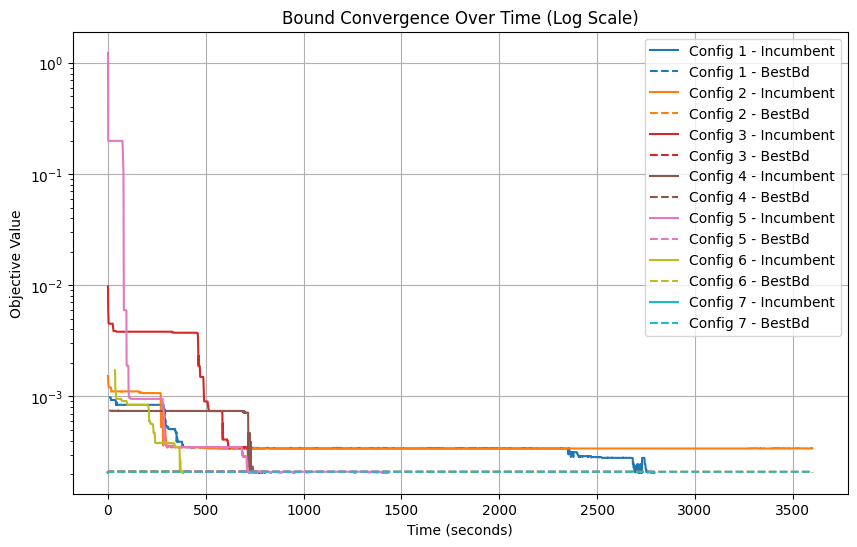

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10',len(grouped_nl['Config'].unique()))
print(colors)
for i, config in enumerate(configs):
    config_data = grouped_nl[grouped_nl['Config'] == config]
    color = colors(i)
    # Plot Incumbent
    plt.plot(config_data['Time'], config_data['Incumbent_mean'], label=f'Config {config} - Incumbent', color=color)
    #plt.fill_between(config_data['Time'], 
                    #  config_data['Incumbent_mean'] - config_data['Incumbent_std'], 
                    #  config_data['Incumbent_mean'] + config_data['Incumbent_std'], 
                    #  color='blue', alpha=0.2)

    # Plot BestBd
    plt.plot(config_data['Time'], config_data['BestBd_mean'], linestyle='--', label=f'Config {config} - BestBd', color=color)
    # plt.fill_between(config_data['Time'], 
    #                  config_data['BestBd_mean'] - config_data['BestBd_std'], 
    #                  config_data['BestBd_mean'] + config_data['BestBd_std'], 
    #                  color='orange', alpha=0.2)

# Set to log scale
plt.yscale('log')

# Add labels
plt.xlabel('Time (seconds)')
plt.ylabel('Objective Value')
plt.title('Bound Convergence Over Time (Log Scale)')
plt.legend()
plt.grid(True)


plt.show()


In [35]:
grouped_nl2 = nl.groupby(['Config', 'CurrentNode']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std']
}).reset_index()

configs = grouped_nl2['Config'].unique()
grouped_nl2.columns = ['Config', 'Node', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl2.head()

,Config,Node,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,0,NaN,NaN,0.000210,0.0
1,1,1,NaN,NaN,0.000206,0.0
2,1,13250,NaN,NaN,0.000210,NaN
3,1,15007,NaN,NaN,0.000210,NaN
4,1,27938,NaN,NaN,0.000210,NaN


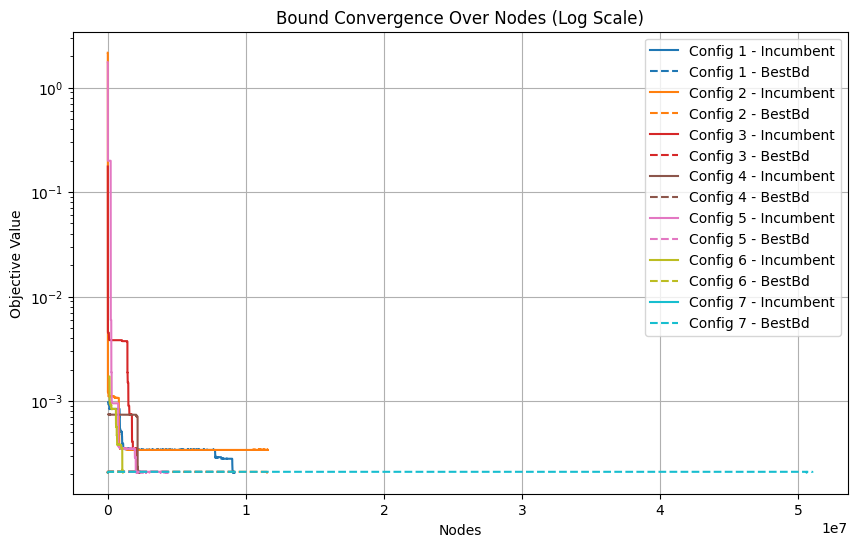

In [36]:
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10',len(grouped_nl['Config'].unique()))
print(colors)
for i, config in enumerate(configs):
    config_data = grouped_nl2[grouped_nl2['Config'] == config]
    color = colors(i)
    # Plot Incumbent
    plt.plot(config_data['Node'], config_data['Incumbent_mean'], label=f'Config {config} - Incumbent', color=color)
    #plt.fill_between(config_data['Time'], 
                    #  config_data['Incumbent_mean'] - config_data['Incumbent_std'], 
                    #  config_data['Incumbent_mean'] + config_data['Incumbent_std'], 
                    #  color='blue', alpha=0.2)

    # Plot BestBd
    plt.plot(config_data['Node'], config_data['BestBd_mean'], linestyle='--', label=f'Config {config} - BestBd', color=color)
    # plt.fill_between(config_data['Time'], 
    #                  config_data['BestBd_mean'] - config_data['BestBd_std'], 
    #                  config_data['BestBd_mean'] + config_data['BestBd_std'], 
    #                  color='orange', alpha=0.2)

# Set to log scale
plt.yscale('log')

# Add labels
plt.xlabel('Nodes')
plt.ylabel('Objective Value')
plt.title('Bound Convergence Over Nodes (Log Scale)')
plt.legend()
plt.grid(True)


plt.show()